,Modulator,Frequency (Hz),Amplitude,Amplitude (dB),Level,Waveform,Coarse Tuning,Fine Tuning,Suggested Frequency (Hz),MIDI Value,Note Name,Base Note
0,Modulator 1,147.124873,8.669343,-2.823901,0.722445,sine_wave,1.0,0,147.124873,50.034452,D3,Yes
1,Modulator 2,74.849028,3.855502,-9.862007,0.321292,sine_wave,0.5,17,74.812998,38.326288,D2,No
2,Modulator 3,520.808977,0.265076,-33.116232,0.022090,sine_wave,2.0,770,520.822052,71.919444,B4,No
3,Modulator 4,820.190109,1.141220,-20.436234,0.095102,sine_wave,5.0,115,820.221170,79.782113,G5,No


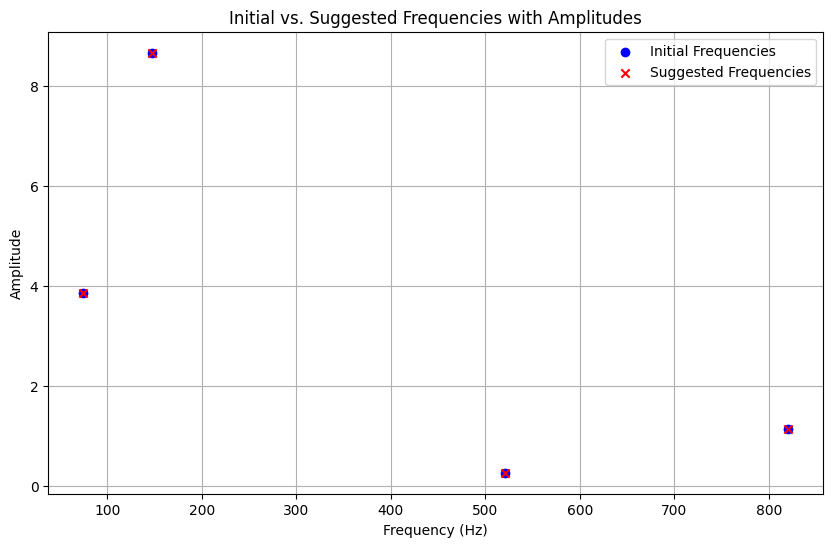

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
import os

# Define the filename
tsv_filename = 'tsv/final_values_fm.tsv'

# Read the DataFrame from the TSV file
input_df = pd.read_csv(tsv_filename, sep='\t')

# Extract values from the DataFrame
frequencies = input_df['Frequency (Hz)'].to_numpy()
amplitudes = input_df['Amplitude'].to_numpy()
waveforms = ['sine_wave'] * len(frequencies)
modulator_numbers = [f'Modulator {i}' for i in input_df['Modulator']]

# Select the first frequency as the base frequency
base_index = 0
base_frequency = frequencies[base_index]

# Calculate optimal coarse and fine tuning relative to the base frequency
def calculate_optimal_coarse_fine(target_frequency, base_frequency):
    valid_coarse_values = np.array([0.5] + list(range(1, 49)))
    best_coarse = None
    best_fine = None
    min_error = float('inf')
    best_suggested_freq = None

    for coarse in valid_coarse_values:
        for fine in range(1000):  # Adjusted fine range to be 0-999
            suggested_freq = coarse * base_frequency * (1 + fine / 1000)
            error = abs(suggested_freq - target_frequency)
            if error < min_error:
                min_error = error
                best_coarse = coarse
                best_fine = fine
                best_suggested_freq = suggested_freq
            if error == 0:
                break  # Perfect match found

    return best_coarse, best_fine, best_suggested_freq

coarse_fine_tuning = [calculate_optimal_coarse_fine(f, base_frequency) for f in frequencies]

# Extract suggested frequencies from coarse and fine tuning results
suggested_frequencies = [cf[2] for cf in coarse_fine_tuning]

# Convert frequencies to MIDI notes
def frequency_to_midi(frequency):
    return 69 + 12 * np.log2(frequency / 440.0)

# MIDI note number to name conversion
def midi_to_note_name(midi):
    note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    octave = int((midi // 12) - 1)  # Ensure the octave is an integer
    note_index = int(midi) % 12
    note_name = note_names[note_index]
    return f"{note_name}{octave}"

midi_values = [frequency_to_midi(f) for f in suggested_frequencies]
note_names = [midi_to_note_name(midi) for midi in midi_values]

# Custom amplitude to dB conversion
# Reference values from this reddit thread: https://www.reddit.com/r/FMsynthesis/comments/e2uouh/modulation_index_in_abletons_operator/
def amplitude_to_db_custom(amplitude):
    return 20 * np.log10(amplitude / 12)

db_values = [amplitude_to_db_custom(amp) for amp in amplitudes]

# Prepare results
results = pd.DataFrame({
    'Modulator': modulator_numbers,
    'Frequency (Hz)': frequencies,
    'Amplitude': amplitudes,
    'Amplitude (dB)': db_values,
    'Level': 10 ** (np.array(db_values) / 20),
    'Waveform': waveforms,
    'Coarse Tuning': [cf[0] for cf in coarse_fine_tuning],
    'Fine Tuning': [cf[1] for cf in coarse_fine_tuning],
    'Suggested Frequency (Hz)': suggested_frequencies,
    'MIDI Value': midi_values,
    'Note Name': note_names
})

# Add a column to mark which frequency is the base note
results['Base Note'] = ['Yes' if i == base_index else 'No' for i in range(len(frequencies))]

# Order the final DataFrame from Modulator 1 to 4
results = results.sort_values(by='Modulator').reset_index(drop=True)

# Display results
display(results)

# Plot the initial frequencies and the suggested frequencies
plt.figure(figsize=(10, 6))
plt.scatter(frequencies, amplitudes, color='blue', label='Initial Frequencies', zorder=2)
plt.scatter(suggested_frequencies, amplitudes, color='red', marker='x', label='Suggested Frequencies', zorder=3)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Amplitude')
plt.title('Initial vs. Suggested Frequencies with Amplitudes')
plt.legend()
plt.grid(True)
plt.show()


In [8]:
# Define the filename
tsv_filename = 'tsv/final_values_fm_operator.tsv'

# Save the DataFrame as a TSV file
results.to_csv(tsv_filename, sep='\t', index=False)

# Print the location where the TSV file was saved
print(f"TSV file was saved at: {os.path.abspath(tsv_filename)}")

TSV file was saved at: C:\Users\egorp\Nextcloud\code\public_repos\audiospylt\experimental\tsv\final_values_fm_operator.tsv
